In [ ]:
!pip install pytorch-lightning
!pip install torchmetrics

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,random_split, SubsetRandomSampler
from torchvision import datasets, transforms
from torchvision import utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -uq "/content/drive/MyDrive/test_dataset.zip" -d "/content"
!unzip -uq "/content/drive/MyDrive/train_dataset.zip" -d "/content"

In [ ]:
!pip install -U albumentations --no-binary qudida, albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install "opencv-python-headless<4.3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [ ]:
alb_valid_transform =A.Compose(
    [
        A.Resize(255,255),
        A.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
        ToTensorV2()
    ]
)

In [ ]:
alb_train_transform =A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=255, width=255),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
        A.OneOf([A.MotionBlur(p=1),
                          A.OpticalDistortion(p=1),
                          A.GaussNoise(p=1)]),
        ToTensorV2()
    ]
)

In [ ]:
import numpy as np
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets.folder import DatasetFolder, default_loader, IMG_EXTENSIONS

class CustomImageFolder(DatasetFolder):
  def __init__(
    self,
    root: str,
    transform: Optional[Callable] = None,
    target_transform: Optional[Callable] = None,
    loader: Callable[[str], Any] = default_loader,
    is_valid_file: Optional[Callable[[str], bool]] = None,
   ):
    super().__init__(
        root,
        loader,
        IMG_EXTENSIONS if is_valid_file is None else None,
        transform=transform,
        target_transform=target_transform,
        is_valid_file=is_valid_file,
    )
    self.imgs = self.samples
  def __getitem__(self, index: int) -> Tuple[Any, Any]:
    """
    Args:
        index (int): Index

    Returns:
        tuple: (sample, target) where target is class_index of the target class.
    """
    path, target = self.samples[index]
    sample = self.loader(path)
    if self.transform is not None:
        try:
            sample = self.transform(sample)
        except Exception:
            sample = self.transform(image=np.array(sample))["image"]
    if self.target_transform is not None:
        target = self.target_transform(target)

    return sample, target

  def __len__(self) -> int:
    return len(self.samples)

In [ ]:
train = CustomImageFolder("/content/train",transform=alb_train_transform) #80
valid = CustomImageFolder("/content/train",transform=alb_valid_transform) #20

valid_size = 0.2

num_train = len(train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx) # 1 3 5 7 11 15 300 
valid_sampler = SubsetRandomSampler(valid_idx) # 2 6 8 10
 

In [ ]:
writer = SummaryWriter()
train_loader = DataLoader(train,batch_size=16,sampler = train_sampler,num_workers=2)
valid_loader = DataLoader(valid,batch_size=16,sampler = valid_sampler,num_workers=2) 
#분류하고싶은 클래스ㅡ이 개수 0~8, 9개


In [ ]:
def imshow(img):
    img = (img/2 + 0.5)
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img,(1,2,0)))

In [ ]:
for i,data in  enumerate(train_loader):
  img,labels = data
  print(img.shape,labels.shape)
  print(labels)
0~8 9 개의 이미지 분류
  if i ==2:
    break

torch.Size([16, 3, 255, 255]) torch.Size([16])
tensor([3, 8, 3, 1, 4, 4, 1, 5, 5, 5, 2, 4, 7, 5, 6, 6])
torch.Size([16, 3, 255, 255]) torch.Size([16])
tensor([6, 2, 0, 4, 8, 4, 7, 0, 1, 8, 4, 5, 3, 5, 0, 7])
torch.Size([16, 3, 255, 255]) torch.Size([16])
tensor([8, 1, 3, 0, 5, 7, 6, 3, 7, 5, 3, 4, 7, 3, 2, 1])


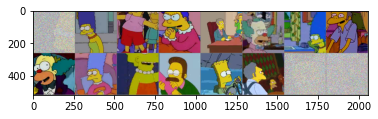

In [ ]:
image, label = next(iter(train_loader))
grid = utils.make_grid(image)
writer.add_image('images', grid, 0)

imshow(grid)

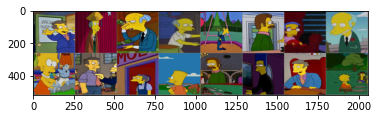

In [ ]:
image, label = next(iter(valid_loader))
grid = utils.make_grid(image)
writer.add_image('images', grid, 0)

imshow(grid)